In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd

#2
df = pd.read_csv("./datasets/SMSSpamCollection.csv",header=None,names=["label","text"])
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

#1
class Multinomial_NB:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, Y):
        labels, label_counts = np.unique(Y, return_counts=True)
        self.labels = labels
        self.label_counts = label_counts
        pi_c = np.array([])
        theta_jc = dict()
        
        for c in range(len(labels)):
            temp = (self.alpha + label_counts[c])/((self.alpha * len(labels)) + len(Y))
            pi_c = np.append(pi_c, temp)
        
        classes = np.array([])
        for c in range(len(labels)):
            class_dict = dict(name=labels[c], words=np.array([]))
        
        words_dict = dict()
        total_word_count = dict()
        for i in range(len(X)):
            words, word_counts = np.unique(X[i], return_counts=True)
            current_class = Y[i]
            
            if current_class in total_word_count:
                total_word_count[current_class] += len(X[i])
            else:
                total_word_count[current_class] = len(X[i])
            
            for j in range(len(words)):
                if words[j] in words_dict:
                    if current_class in words_dict[words[j]]:
                        words_dict[words[j]][current_class] += word_counts[j]
                    else:
                        words_dict[words[j]][current_class] = word_counts[j]
                else:
                    words_dict[words[j]] = dict()
                    words_dict[words[j]][current_class] = word_counts[j]
                    
        for j in range(len(words_dict)):
            words_dict_keys = list(words_dict.keys())
            word_classes_dict = dict()
            for c in range(len(words_dict[words_dict_keys[j]])):
                classes_dict_keys = list(words_dict[words_dict_keys[j]].keys())
                temp = (self.alpha + words_dict[words_dict_keys[j]][classes_dict_keys[c]])/((self.alpha * len(X[i])) + total_word_count[classes_dict_keys[c]])
                theta_jc[words_dict_keys[j]] = dict()
                theta_jc[words_dict_keys[j]][classes_dict_keys[c]] = temp
                 
        self.pi_c = pi_c
        self.theta_jc = theta_jc
    
    def predict(self, X):
        log_l = np.array([])
        for i in range(len(X)):
            words, word_counts = np.unique(X[i], return_counts=True)
            row_class_probs = dict()
            for c in range(len(self.labels)):
                temp_log_pi = np.log(self.pi_c[c]**self.label_counts[c])
                
                temp_log_sum_theta = 0
                for j in range(len(X[i])):
                    word_count = word_counts[list(words).index(X[i][j])]
                    temp = (self.theta_jc[X[i][j]][self.labels[c]]**word_count)*((1-self.theta_jc[X[i][j]][self.labels[c]])**(len(X[i])-word_count))
                    temp_log_sum_theta += np.log(temp)
                
                row_class_probs[self.labels[c]] = temp_log_pi + temp_log_sum_theta
            
            class_chosen = row_class_probs.keys()[0]
            for key in row_class_probs:
                if row_class_probs[key] > row_class_probs[class_chosen]:
                    class_chosen = key

            log_l = np.append(log_l, class_chosen)
        
        return log_l
    
    def predict_proba(self, X):
        pass
    
    def predict_log_proba(self, X):
        pass

[nltk_data] Downloading package punkt to /Users/mbennett/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
#3
df['length'] = df['text'].map(lambda text: len(text))
df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,71.527035,58.330761,2.0,33.0,52.0,93.0,910.0
spam,747.0,139.119143,28.998900,13.0,133.0,149.0,158.0,224.0


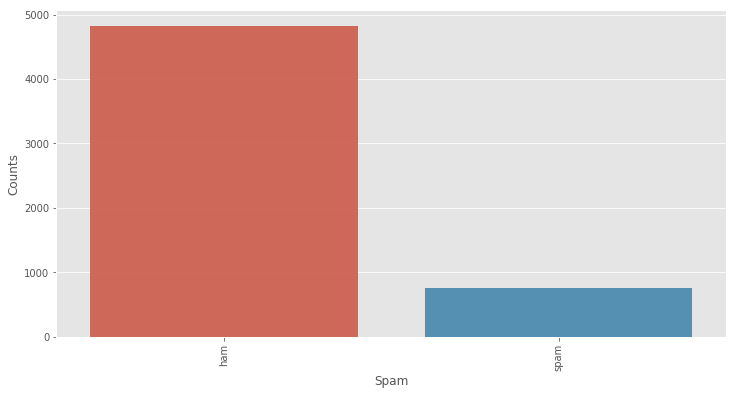

In [12]:
#4
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [13]:
#5
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)))
df['text_stemmed'] = df['text'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text)))

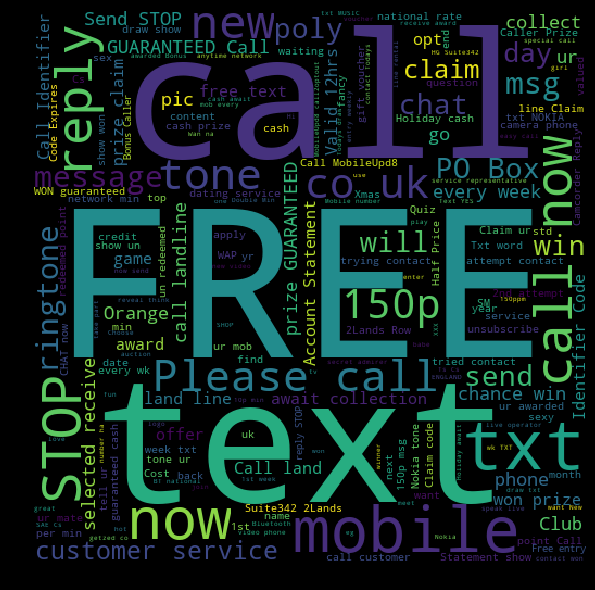

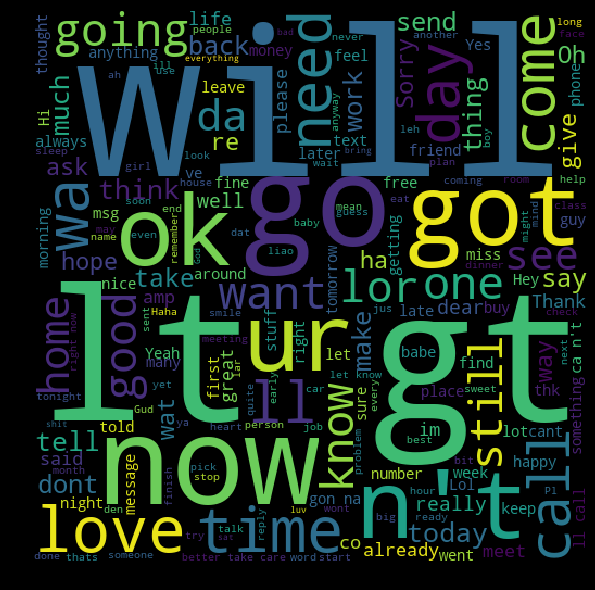

In [14]:
#6
df.describe()
spam_words = ''.join(list(df[df['label']=='spam']['text_lemmatized']))
spam_wordcloud = WordCloud(width=512, height=512).generate(spam_words)
ham_words = ''.join(list(df[df['label']=='ham']['text_lemmatized']))
ham_wordcloud = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [15]:
#7
X = df["text_lemmatized"]
y = df["label"]

count_vect = CountVectorizer()
X_count = count_vect.fit_transform(X).toarray()
X = pd.DataFrame(X_count, columns=count_vect.get_feature_names())
sums = np.sum(X[y != 'ham'], axis=0)
# l
len(y[y != 'ham'])
# np.sum(sums)
class MultinomialNB:
    def __init__(self, alpha=1):
        self.alpha = alpha
        
    def fit(self, X, Y):
        labels = np.unique(Y)
        pi_c = np.array([])
        theta_jc = np.ndarray((len(X), len(labels)))
        self.num_docs_in_c = np.array([])
        
        for c in range(len(labels)):
            current_class = labels[c]
            
            num_of_samples_in_c = len(Y[Y == current_class])
            num_of_samples = len(Y)
            
            self.num_docs_in_c = np.append(self.num_docs_in_c, num_of_samples_in_c)
            
            pi_c = np.append(pi_c, (self.alpha + num_of_samples_in_c)/((len(labels)*self.alpha)+ num_of_samples))
            
            feature_counts_in_c = np.sum(X[Y == current_class], axis=0) 
            
            for j in range(len(X)):
                temp_class_c_theta = (self.alpha + feature_counts_in_c[j])/(len(X)*self.alpha + np.sum(feature_counts_in_c))
                theta_jc[j][c] = temp_class_c_theta
        
        print("PI_c: ", pi_c)
        print("THETA_jc: ", theta_jc)
        self.labels = labels
        self.pi_c = pi_c
        self.theta_jc = theta_jc
        
    def predict(self, X):
        predicted_classes = np.array([])
        probabilities = self.predict_proba(X)
        
        for i in range(len(probabilities)):
            class_chosen = 0
            for c in range(probabilities.shape[1]):
                if probabilities[i][c] > probabilities[i][class_chosen]:
                    class_chosen = c

            predicted_classes = np.append(predicted_classes, self.labels[class_chosen])
        
        return predicted_classes
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict_log_proba(self, X):
        log_probabilities = np.ndarray((len(X), len(self.labels)))
        print(self.theta_jc.shape)
        for i in range(len(X)):
            pi_sum = 0
            for c in range(len(self.labels)):
                pi_sum += self.pi_c[c]**(self.num_docs_in_c)
                
                theta_jc_sum = 0
                for j in range(4458):
                    theta_jc1 = self.theta_jc[j][c]**X[i][j]
                    theta_jc2 = 1 - (self.theta_jc[j][c]**X[i][j])
                    theta_jc_sum += theta_jc1 * theta_jc2
                    
                log_probabilities[i][c] = pi_sum[c] + theta_jc_sum
        
        print(log_probabilities)
        return log_probabilities
    


In [7]:
# X.values[0][0]
# len(X_test.values[4458][0])
#8 ,9
# df1 = df.sample(frac=1) 
# X = df["text_lemmatized"].values
# X = [text.split(' ') for textin X]
# y = df["label"].values

In [16]:
#10
def partition(feature_matrix, target_vector, t):
    last_index_taken = len(feature_matrix) - int(round(len(feature_matrix) * t))
    X_train = feature_matrix[0:last_index_taken][:]
    X_test = feature_matrix[last_index_taken:len(feature_matrix)][:]
    y_train = target_vector[0:last_index_taken]
    y_test = target_vector[last_index_taken:len(target_vector)]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = partition(X, y, 0.2)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_preds = mnb.predict(X_test.values)
y_preds

PI_c:  [0.86482851 0.13517149]
THETA_jc:  [[1.81709156e-05 5.93023883e-04]
 [1.81709156e-05 1.40169281e-03]
 [3.63418313e-05 5.39112621e-05]
 ...
 [5.26956553e-04 5.39112621e-05]
 [5.45127469e-05 5.39112621e-05]
 [1.81709156e-05 1.07822524e-04]]
(4459, 2)
[[0.0121241  0.00381502]
 [0.02132588 0.01480585]
 [0.03709123 0.00939318]
 ...
 [0.02080627 0.01317475]
 [0.06330002 0.03319473]
 [0.01315673 0.00166879]]


array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U32')

In [17]:
def accuracy(predicted, actual):
    accuracy = np.sum(predicted == actual)
    return accuracy/len(actual)
def kfold(folds, data, labels, model, model_args, score_function,seed=None):
    if (seed == None):
        seed = np.random.randint(1,500)
    data = np.asarray(data)
    #print(data.shape)
    labels = np.asarray(labels)
    #print(labels.shape)
    np.random.seed(seed)
    np.random.shuffle(data)
    np.random.seed(seed)
    np.random.shuffle(labels)
    
    datafolds = np.array_split(data,folds)
    labelfolds = np.array_split(labels,folds)
    
    scores = []
    true_labels = np.array([])
    predictions = np.array([])

    for fold in range(len(datafolds)):
        trainingdatafolds = np.vstack([data for k, data in enumerate(datafolds) if k not in [fold]])
        trainingdatafolds = trainingdatafolds.reshape(-1,data.shape[1])
        trainingdata = np.empty((0,data.shape[1]), int)
        trainingdata = np.asmatrix(np.append(trainingdata, trainingdatafolds, axis=0))
        
        traininglabelfolds = np.concatenate([label for k, label in enumerate(labelfolds) if k not in [fold]])
        traininglabelfolds = traininglabelfolds.reshape(-1,1)
        traininglabels = np.empty((0,1), int)
        traininglabels = np.append(traininglabels, traininglabelfolds, axis=0)
    
        testingdata = np.asmatrix(datafolds[fold])
        testinglabels = labelfolds[fold]
        
        calledmodel = model(model_args)
        calledmodel.fit(X=trainingdata, Y=traininglabels)
        preds = calledmodel.predict(testingdata)
        score = score_function(preds,testinglabels)
        scores = np.append(scores,score)
        true_labels = np.append(labels,testinglabels)
        predictions = np.append(predictions,preds)
    
    
    results={'average_score':np.mean(scores),'predicted_values':predictions, 'true_values':true_labels}

    return results

def confusion_matrix(predicted, actual):
    cm = np.zeros((len(np.unique(actual)), len(np.unique(actual))))
    print(cm)
    for i, j in zip(predicted, actual):
        cm[i][j] += 1
    return cm

In [6]:
#11
alpha = [0.1, 0.5, 1.0, 1.5, 2.0]
value_obj = dict()
results_arr = np.array([])

for a in range(len(alpha)):
    results=kfold(5,X_train, y_train, MultinomialNB, alpha[a], accuracy)
    value_obj['hyperparameter_values'] = hyperparameter_values
    value_obj = {
        'hyperparameter_values': hyperparameter_values,
        'average_score': results['average_score']
    }
    results_arr = np.append(results_arr, value_obj)
results_arr = sorted(results_arr, key=lambda k: k['average_score'])
results_arr[0]

NameError: name 'np' is not defined

In [18]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def precision(predicted, actual):
    tp = 0
    fp = 0
    for i in range(0, len(predicted)):
        if predicted[i] == actual[i] and actual[i] == 1:
            tp += 1
        elif predicted[i] != actual[i] and actual[i] == 0:
            fp += 1
    if (tp + fp) == 0:
        return 0
    
    return tp/(tp + fp)

def recall(predicted, actual):
    tp = 0
    fn = 0
    for i in range(0, len(predicted)):
        if predicted[i] == actual[i] and actual[i] == 1:
            tp += 1
        elif predicted[i] != actual[i] and actual[i] == 1:
            fn += 1
    if (tp + fn) == 0:
        return 0
    
    return tp/(tp + fn)

def f1_score(predicted, actual):
    rec = recall(predicted, actual)
    prec = precision(predicted, actual)
    if (prec + rec) == 0:
        return 0
    
    return 2*((prec*rec)/(prec+rec))

def roc_curve(true_classes, class_probabilities):
    true_classes, class_probabilities = np.asarray(true_classes) , np.asarray(class_probabilities)
    tpr_values=[]
    fpr_values=[]
    for threshold in range(100):
        predicted_classes=(class_probabilities > float(threshold/100.)).astype(int)
        fpr=np.sum(predicted_classes[np.where(predicted_classes == 1 )]  != true_classes[np.where(predicted_classes == 1 )])/true_classes[np.where(true_classes == 0 )].shape[0]
        tpr=np.sum(predicted_classes[np.where(predicted_classes == 1 )]  == true_classes[np.where(predicted_classes == 1 )])/true_classes[np.where(true_classes == 1 )].shape[0]
        fpr_values.append(fpr)
        tpr_values.append(tpr)
    return fpr_values,tpr_values

y_test_v = y_test.values
y_preds_v = np.ndarray(y_preds.shape).astype(int)
for i in range(len(y_test)):
    if y_test_v[i] == 'ham':
        y_test_v[i] = 0
    if y_preds[i] == 'ham':
        y_preds_v[i] = 0
    if y_test_v[i] == 'spam':
        y_test_v[i] = 1
    if y_preds[i] == 'spam':
        y_preds_v[i] = 1
        
# print(y_preds_v)
# print(list(zip(y_test, y_preds)))
print(y_preds)
print(y_test_v)
print(accuracy(y_preds_v, y_test_v))
print(confusion_matrix(y_preds_v, y_test_v))
print(precision(y_preds_v, y_test_v))
print(recall(y_preds_v, y_test_v))
print(f1_score(y_preds_v, y_test_v))

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']
[0 1 0 ... 0 0 0]
0.9022421524663677
[[0. 0.]
 [0. 0.]]
[[896.  35.]
 [ 74. 110.]]
0.5978260869565217
0.7586206896551724
0.668693009118541


In [ ]:
#15,16,17
def onehot(Y):  
    U_index = np.unique(Y, return_inverse=1)[1]
    Y_one_hot=(U_index.ravel()[:,None] == np.arange(U_index.max()+1)).astype(int)
    return Y_one_hot
def softmax(score):
    Y_proba=np.exp(score).T/(np.sum(np.exp(score),axis=1))
    return Y_proba.T
def cross_entropy_loss(Y_one_hot, Y_proba):
    ce_cost=-Y_one_hot*np.log2(Y_proba)
    return ce_cost[np.nonzero(ce_cost)].mean()

In [ ]:
#18,27
class Softmax_Regression:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None,lambd=0.0,early_stopping=False, validation_fraction=0.1,**kwargs):
        if early_stopping == True:
            X, X_val, Y, Y_val=partition(X, Y, validation_fraction)
            accuracies=[]
            accuracy=0.0
        Y=onehot(Y)
        bias_term=np.ones((X.shape[0], 1))
        X=np.hstack((bias_term,X))
        X=np.asarray(X)
        theta=np.zeros((X.shape[1], Y.shape[1]))
        
        for i in range(epochs):
            scores=X.dot(theta)
            Y_proba=softmax(scores)
            ce=cross_entropy_loss(Y, Y_proba)
            if regularizer==None:
                theta=theta-(learning_rate/X.shape[0])*np.dot(X.T,(Y_proba-Y))
            elif regularizer=='l1':
                theta=theta-(learning_rate/X.shape[0]*np.dot(X.T,(Y_proba-Y))+lambd*np.sign(theta))
            else:
                theta=theta-(learning_rate/X.shape[0]*np.dot(X.T,(Y_proba-Y))+lambd*theta)
            new_scores=X.dot(theta)
            new_Y_proba=softmax(new_scores)
            new_ce=cross_entropy_loss(Y, new_Y_proba)
 
            if tol is not None:
                if new_ce > ce-tol:
                    break
            if early_stopping == True:
                X_val=np.asarray(X_val)
                bias_term=np.ones((X_val.shape[0], 1))
                X_val=np.hstack((bias_term,X_val))
                scores=X_val.dot(self.theta)
                Y_proba=softmax(scores)
                new_accuracy=accuracy(np.argmax(Y_proba,axis=1),y_val)
                accuracies.append(new_accuracy)
                if new_accuracy < accuracy:
                    break
                
        self.theta=theta
        if early_stopping == True:
            return accuracies
        
    def predict(self, X):
        X=np.asarray(X)
        bias_term=np.ones((X.shape[0], 1))
        X=np.hstack((bias_term,X))
        scores=X.dot(self.theta)
        Y_proba=softmax(scores)
        return np.argmax(Y_proba,axis=1)
    

In [ ]:
#helper functions
def partition(feature_matrix, target_vector, t):
    last_index_taken = len(feature_matrix) - int(round(len(feature_matrix) * t))
    X_train = feature_matrix[0:last_index_taken,:]
    X_test = feature_matrix[last_index_taken:len(feature_matrix), :]
    y_train = target_vector[0:last_index_taken]
    y_test = target_vector[last_index_taken:len(target_vector)]
    return X_train, X_test, y_train, y_test

def kfold(folds, data, labels, model, model_args, score_function,seed=None):
    if (seed == None):
        seed = np.random.randint(1,500)
    data = np.asarray(data)
    #print(data.shape)
    labels = np.asarray(labels)
    #print(labels.shape)
    np.random.seed(seed)
    np.random.shuffle(data)
    np.random.seed(seed)
    np.random.shuffle(labels)
    
    datafolds = np.array_split(data,folds)
    labelfolds = np.array_split(labels,folds)
    
    scores = []
    true_labels = np.array([])
    predictions = np.array([])

    for fold in range(len(datafolds)):
        trainingdatafolds = np.vstack([data for k, data in enumerate(datafolds) if k not in [fold]])
        trainingdatafolds = trainingdatafolds.reshape(-1,data.shape[1])
        trainingdata = np.empty((0,data.shape[1]), int)
        trainingdata = np.asmatrix(np.append(trainingdata, trainingdatafolds, axis=0))
        
        traininglabelfolds = np.concatenate([label for k, label in enumerate(labelfolds) if k not in [fold]])
        traininglabelfolds = traininglabelfolds.reshape(-1,1)
        traininglabels = np.empty((0,1), int)
        traininglabels = np.append(traininglabels, traininglabelfolds, axis=0)
    
        testingdata = np.asmatrix(datafolds[fold])
        testinglabels = labelfolds[fold]
        
        calledmodel = model()
        calledmodel.fit(X=trainingdata, Y=traininglabels, kwargs=model_args)
        preds = calledmodel.predict(testingdata)
        score = score_function(preds,testinglabels)
        scores = np.append(scores,score)
        true_labels = np.append(labels,testinglabels)
        predictions = np.append(predictions,preds)
    
    
    results={'average_score':np.mean(scores),'predicted_values':predictions, 'true_values':true_labels}

    return results

def min_max_scale(X):
    mins=np.amin(X,axis=0)
    maxs=np.amax(X,axis=0)
    scaleX=np.zeros((X.shape[0],X.shape[1]))
    scaleX=(X-mins)/(maxs-mins)
    return np.asmatrix(scaleX)

In [ ]:
#19,20,21,23,24
from sklearn.datasets import load_iris
data = load_iris()
Y=data['target']
X=data['data']
np.random.seed(123)
Y= np.random.permutation(Y)

np.random.seed(123)
X= np.random.permutation(X)
df=pd.DataFrame(X)
print(df.describe())
X=min_max_scale(X)

X_train, X_test, Y_train, Y_test =partition(X, Y, 0.2)

In [ ]:
#22
import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [ ]:
#25
lambd_values= [1.0,0.1,0.01, 0.001, 0.0001]
tol_values=[None,0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
learning_rate_values = [ 0.1, 0.01, 0.001]
regularizer_values= ['l1', 'l2']
value_obj = dict()
results_arr = np.array([])

for lambd in range(len(lambd_values)):
    for tol in range(len(tol_values)):
        for learning_rate in range(len(learning_rate_values)):
            for regularizer in range(len(regularizer_values)):
                hyperparameter_values={'lambd_values':lambd_values[lambd],'tol_values':tol_values[tol],'learning_rate':learning_rate_values[learning_rate],'regularizer':regularizer_values[regularizer]}
                results=kfold(5,X_train, Y_train, Softmax_Regression, hyperparameter_values,accuracy)
                value_obj['hyperparameter_values'] = hyperparameter_values
                value_obj = {
                    'hyperparameter_values': hyperparameter_values,
                    'average_score': results['average_score']
                }
                results_arr = np.append(results_arr, value_obj)
results_arr = sorted(results_arr, key=lambda k: k['average_score'])
results_arr[0]

In [ ]:
#26
SR=Softmax_Regression()
SR.fit(X_train,Y_train)
y_preds=SR.predict(X_test)
print(accuracy(Y_test,y_preds))
print(confusion_matrix(Y_test,y_preds))

In [ ]:
#28
class Stochastic_Softmax_Regression:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None,lambd=0.0,early_stopping=False, validation_fraction=0.1,**kwargs):
        if early_stopping == True:
            X, X_val, Y, Y_val=partition(X, Y, validation_fraction)
            accuracies=[]
            accuracy=0.0
        Y=onehot(Y)
        bias_term=np.ones((X.shape[0], 1))
        X=np.hstack((bias_term,X))
        X=np.asarray(X)
        theta=np.zeros((X.shape[1], Y.shape[1]))
        import random
        
        for i in range(epochs):
            row=random.randint(0,X.shape[0]-1)
            scores=X.dot(theta)
            Y_proba=np.exp(scores.T)/(np.sum(np.exp(scores)))
            ce=cross_entropy_loss(Y, Y_proba)
            if regularizer==None:
                theta=theta-(learning_rate)*np.asmatrix(X[row,:]).T*np.asmatrix(Y_proba[row,:]-Y[row,:])
            elif regularizer=='l1':
                theta=theta-(learning_rate*np.dot(X[row,:].T,(Y_proba[row,:]-Y[row,:]))+lambd*np.sign(theta))
            else:
                theta=theta-(learning_rate*np.dot(X[row,:].T,(Y_proba[row,:]-Y[row,:]))+lambd*theta)
            new_scores=X.dot(theta)
            new_Y_proba=softmax(scores)
            new_ce=cross_entropy_loss(Y, Y_proba)
            if tol is not None:
                if new_ce > ce-tol:
                    break
            if early_stopping == True:
                X_val=np.asarray(X_val)
                bias_term=np.ones((X_val.shape[0], 1))
                X_val=np.hstack((bias_term,X_val))
                scores=X_val.dot(self.theta)
                Y_proba=softmax(scores)
                new_accuracy=accuracy(np.argmax(Y_proba,axis=1),y_val)
                accuracies.append(new_accuracy)
                if new_accuracy < accuracy:
                    break
                
        self.theta=theta
        if early_stopping == True:
            return accuracies
        
    def predict(self, X):
        X=np.asarray(X)
        bias_term=np.ones((X.shape[0], 1))
        X=np.hstack((bias_term,X))
        scores=X.dot(self.theta)
        Y_proba=softmax(scores)
        return np.argmax(Y_proba,axis=1)